# Name: Bhavesh Kewalramani
# Roll No.: A-25
# Section: A
# Semester: VII
# Shift: I
# Batch: A1

In [1]:
import numpy as np
import pandas as pd

In [2]:
titanic_data = pd.read_csv("titanic dataset.csv", usecols=["survived", "sex", "age", "sibsp", "parch", "fare", "embarked"]).dropna()
titanic_data_encoded = pd.get_dummies(titanic_data, columns=["sex", "embarked"])

titanic_data_train = titanic_data_encoded.sample(frac=0.7)
titanic_data_test = titanic_data_encoded[~titanic_data_encoded.index.isin(titanic_data_train.index)]
titanic_data_train.head()

,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
371,True,45.0,0,2,30.0000,1,0,0,0,1
252,False,61.0,1,3,262.3750,0,1,1,0,0
28,True,35.0,0,0,135.6333,1,0,0,0,1
304,True,60.0,1,0,75.2500,1,0,1,0,0
777,True,19.0,0,0,8.0500,0,1,0,0,1


In [3]:
class Node():
    def __init__(self, left_child, right_child, split, layer=None):
        self.right_child = right_child
        self.left_child = left_child
        self.split = split
        self.type = "Node"

class Leaf():
    def __init__(self, value):
        self.value = value
        self.type = "Leaf"

class DecisionTreeClassifier():
    
    def __init__(self, method="gini", max_depth=50, min_samples_split=20, max_features=None):
        self.method = method
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features

        self.root_node = None
        self.depth = 0
        
    def calc_entropy(self, X):
        weighted_average_of_props = 0
        for categ in np.unique(X):
            prop = np.where(X == categ, 1, 0).sum() / len(X)
            weighted_average_of_props += prop * np.log10(prop)
        return -1 * weighted_average_of_props
    
    def calc_gini(self, X):
        square_props = 0
        for categ in np.unique(X):
            prop = np.where(X == categ, 1, 0).sum() / len(X)
            square_props += prop ** 2
        return 1 - square_props
    
    def information_gain(self, S, S_l, S_r):
        #  if entropy is used as impurity measurement
        if self.method == "entropy":
            S_impurity = self.calc_entropy(S)
            S_l_impurity = self.calc_entropy(S_l)
            S_r_impurity = self.calc_entropy(S_r)
            
        #  if gini index is used as impurity measurement (default due to being less computing power intensiv)
        elif self.method == "gini":
            S_impurity = self.calc_gini(S)
            S_l_impurity = self.calc_gini(S_l)
            S_r_impurity = self.calc_gini(S_r)
            
        else:
            raise ValueError("expected method to be 'gini' or 'entropy'")
        
        return S_impurity - (S_l_impurity * (len(S_l) / len(S)) 
                             + S_r_impurity * (len(S_r) / len(S)))
    
    def get_best_split(self, X, y):
        best_var, best_value, best_score = None, None, 0
        
        if self.max_features == None:
            variables = range(X.shape[1])
        else:
            variables = np.random.choice([i for i in range(X.shape[1])], size=self.max_features, replace=False)
        
        for var_i in variables:
            for value in np.unique(X[:-1, var_i]):
                score = self.information_gain(y,                        # targe before split
                                              y[X[:, var_i] <= value],  # targe after split left child
                                              y[X[:, var_i] > value])   # targe after split right child
                if score > best_score:
                    best_var, best_value, best_score = var_i, value, score
                    
        return best_var, best_value
    
    def build_tree(self, X, y):
        best_var, best_value = self.get_best_split(X, y)
        
        #  check wether to split or create leaf node
        if (best_var == None)|(len(X) < self.min_samples_split)|(self.depth >= self.max_depth):
            return Leaf(np.unique(y)[np.argmax(np.unique(y, return_counts=True)[1])])
        else:
            self.depth += 1
            return Node(self.build_tree(X[X[:, best_var] <= best_value], y[X[:, best_var] <= best_value]), # left child
                        self.build_tree(X[X[:, best_var] > best_value], y[X[:, best_var] > best_value]), # right child
                        (best_var, best_value)) # save split
    
    def get_prediction(self, node, row):
        if node.type == "Node":
            if row[node.split[0]] > node.split[1]:
                return self.get_prediction(node.right_child, row)
            else:
                return self.get_prediction(node.left_child, row)
        else:
            return node.value
        
    def fit(self, X, y):
        self.depth = 0
        self.root_node = self.build_tree(X, y)
                    
    def predict(self, X):
        predictions = [self.get_prediction(self.root_node, row) for row in X]
        return np.array(predictions)
    
    #  functions added for "visualising" structure:
    def get_tree_struckture(self, node, prev_layer):
        if node.type == "Node":
            print(f"walked node on depth lvl. {prev_layer+1}")
            return self.get_tree_struckture(node.left_child, prev_layer+1), self.get_tree_struckture(node.right_child, prev_layer+1)
        else:
            print(f"walked leaf on depth lvl. {prev_layer+1} with the value {node.value}")
                
    def struckture(self):
        self.get_tree_struckture(self.root_node, 0)

In [4]:
X_train = titanic_data_train.loc[:, titanic_data_train.columns!="survived"].to_numpy() # select everything but the target
y_train = titanic_data_train.loc[:, "survived"].to_numpy() # select the target

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

In [5]:
classifier.struckture()

walked node on depth lvl. 1
walked node on depth lvl. 2
walked node on depth lvl. 3
walked leaf on depth lvl. 4 with the value True
walked leaf on depth lvl. 4 with the value False
walked node on depth lvl. 3
walked node on depth lvl. 4
walked node on depth lvl. 5
walked node on depth lvl. 6
walked node on depth lvl. 7
walked node on depth lvl. 8
walked leaf on depth lvl. 9 with the value True
walked node on depth lvl. 9
walked node on depth lvl. 10
walked node on depth lvl. 11
walked node on depth lvl. 12
walked leaf on depth lvl. 13 with the value False
walked leaf on depth lvl. 13 with the value False
walked node on depth lvl. 12
walked leaf on depth lvl. 13 with the value False
walked node on depth lvl. 13
walked leaf on depth lvl. 14 with the value True
walked node on depth lvl. 14
walked leaf on depth lvl. 15 with the value False
walked leaf on depth lvl. 15 with the value True
walked node on depth lvl. 11
walked leaf on depth lvl. 12 with the value False
walked node on depth lvl

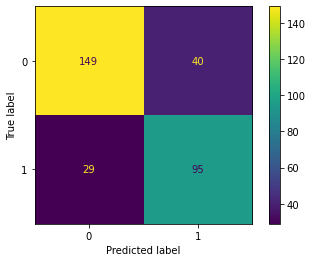

accuracy = 0.7795527156549521,
recall = 0.7661290322580645,
precision = 0.7037037037037037,
f1-score = 0.7335907335907337


In [6]:
import matplotlib.pyplot as plt

X_test = titanic_data_test.loc[:, titanic_data_test.columns!="survived"].to_numpy() # select everything but the target
y_test = titanic_data_test.loc[:, "survived"].to_numpy() # select the target

#  make predictions:
predictions = classifier.predict(X_test)

#  confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, labels=[0, 1])
cm_displ = ConfusionMatrixDisplay(cm)
cm_displ.plot()
plt.show()

#  calculate accuracy:
accuracy = np.mean(predictions==y_test)

#  calculate recall:
recall = cm[1, 1]/cm[1, :].sum() # of the total actual positives, how much were classified correctly

#  calculate precision:
precision = cm[1, 1]/cm[:, 1].sum() # of all predicted positives, how much were True positives

#  not that neccessary for this problem, but for the completeness:
f1 = 2 * ((recall * precision)/(recall + precision)) 

print(f"accuracy = {accuracy},\nrecall = {recall},\nprecision = {precision},\nf1-score = {f1}")

In [7]:
print(predictions)

[ True  True False  True  True  True  True  True False  True  True False
  True  True  True  True  True  True False  True False  True False  True
 False  True False False  True False  True  True  True False  True False
 False  True  True False False  True False  True False  True False False
 False  True  True  True False  True False  True  True  True False  True
  True  True  True  True False  True  True  True  True  True  True False
  True False  True False  True False  True False  True  True False False
  True  True False  True False False  True False  True  True  True False
  True False  True False  True  True False False False False False False
 False False False  True  True False  True False  True  True  True False
 False False False False False False  True  True False  True  True False
 False False False  True False False False False  True  True False  True
  True  True False False False  True False  True  True False  True False
 False False  True  True  True  True  True False  T